## 1. Data

In [1]:
import pandas as pd
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns

ds = load_dataset("TIGER-Lab/MMLU-Pro")
splits = {
    'test': 'data/test-00000-of-00001.parquet',
    'validation': 'data/validation-00000-of-00001.parquet'
}
df_test = pd.read_parquet("hf://datasets/TIGER-Lab/MMLU-Pro/" + splits["test"])
df_validation = pd.read_parquet("hf://datasets/TIGER-Lab/MMLU-Pro/" + splits["validation"])
df_test['question_length'] = df_test['question'].apply(len)
df_test['num_options'] = df_test['options'].apply(lambda x: len(x.tolist()) if isinstance(x, np.ndarray) else len(x))
df_test['difficulty'] = pd.qcut(df_test['question_length'], q=3, labels=['easy', 'medium', 'hard'])
category_counts = df_test['category'].value_counts()

## 2. Data Review

In [2]:
print(df_test.info())
print(df_test.describe())
print(df_test.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12032 entries, 0 to 12031
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   question_id   12032 non-null  int64 
 1   question      12032 non-null  object
 2   options       12032 non-null  object
 3   answer        12032 non-null  object
 4   answer_index  12032 non-null  int64 
 5   cot_content   12032 non-null  object
 6   category      12032 non-null  object
 7   src           12032 non-null  object
dtypes: int64(2), object(6)
memory usage: 752.1+ KB
None
        question_id  answer_index
count  12032.000000  12032.000000
mean    6168.925033      4.195894
std     3519.353467      2.854859
min       70.000000      0.000000
25%     3127.750000      2.000000
50%     6176.500000      4.000000
75%     9212.250000      7.000000
max    12256.000000      9.000000
   question_id                                           question  \
0           70  Typical advertising regu

In [3]:
print(df_test.isnull().sum())

question_id     0
question        0
options         0
answer          0
answer_index    0
cot_content     0
category        0
src             0
dtype: int64


It seems like there are no missing values in any of the columns in the df_test DataFrame. Each column has complete data.

In [4]:
print(df_test.dtypes)

question_id      int64
question        object
options         object
answer          object
answer_index     int64
cot_content     object
category        object
src             object
dtype: object


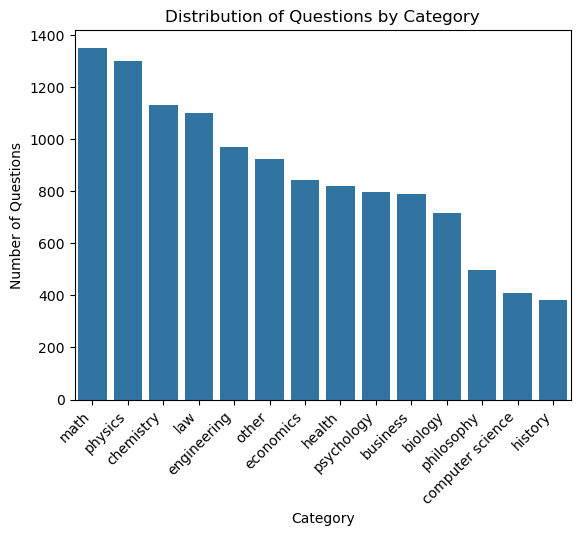

In [23]:
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Questions by Category')
plt.xlabel('Category')
plt.ylabel('Number of Questions')
plt.show()


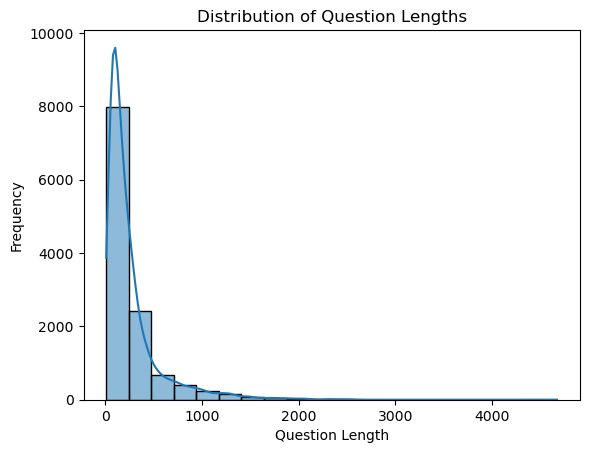

In [24]:
question_lengths = df_test['question'].str.len()
sns.histplot(question_lengths, bins=20, kde=True)
plt.title('Distribution of Question Lengths')
plt.xlabel('Question Length')
plt.ylabel('Frequency')
plt.show()


## Logistic Regression

In [25]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Encode the 'category' column using LabelEncoder
df_test['category_encoded'] = le.fit_transform(df_test['category'])

# Select features and target
X = df_test[['num_options', 'category_encoded']]
y = df_test['difficulty']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Logistic Regression model
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

# Make predictions
y_pred = lr.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.3601994183631076
Classification Report:
              precision    recall  f1-score   support

        easy       0.41      0.59      0.48       821
        hard       0.35      0.48      0.41       773
      medium       0.04      0.01      0.01       813

    accuracy                           0.36      2407
   macro avg       0.27      0.36      0.30      2407
weighted avg       0.27      0.36      0.30      2407



## Random Forest 

In [16]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_test['category_encoded'] = le.fit_transform(df_test['category'])


In [17]:
X = df_test[['num_options', 'category_encoded']]
y = df_test['difficulty']

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [19]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)


RandomForestClassifier()

In [20]:
from sklearn.metrics import accuracy_score, classification_report
y_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.5484004985459078
Classification Report:
              precision    recall  f1-score   support

        easy       0.56      0.64      0.60       821
        hard       0.64      0.44      0.52       773
      medium       0.48      0.56      0.52       813

    accuracy                           0.55      2407
   macro avg       0.56      0.55      0.55      2407
weighted avg       0.56      0.55      0.55      2407



## The following code is optional

I am only exploring how does clustering works in python.

In [26]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Encode 'category' as a numeric feature for clustering
le = LabelEncoder()
df_test['category_encoded'] = le.fit_transform(df_test['category'])

# Create a feature matrix using 'question_length', 'num_options', and 'category_encoded'
X = df_test[['question_length', 'num_options', 'category_encoded']].values
from sklearn.cluster import KMeans

# Apply KMeans clustering with 3 clusters (easy, medium, hard)
kmeans = KMeans(n_clusters=3, random_state=42)
df_test['cluster'] = kmeans.fit_predict(X)

# Inspect the clusters
df_test[['question', 'question_length', 'num_options', 'category', 'cluster']].head()
# Show samples of questions in each cluster
for cluster_id in df_test['cluster'].unique():
    print(f"Cluster {cluster_id} sample:")
    print(df_test[df_test['cluster'] == cluster_id].sample(5)[['question', 'difficulty']])
    print("\n")
# Map clusters to difficulty labels (after inspecting)
cluster_to_difficulty = {
    0: 'easy',    # Cluster 0 is easy
    1: 'medium',  # Cluster 1 is medium
    2: 'hard'     # Cluster 2 is hard
}

# Assign difficulty labels based on cluster
df_test['cluster_difficulty'] = df_test['cluster'].map(cluster_to_difficulty)

# Check the updated DataFrame
print(df_test[['question', 'difficulty', 'cluster', 'cluster_difficulty']].head())


Cluster 0 sample:
                                                question difficulty
3963   A PO3- radical produces a pair of lines separa...     medium
7168   Suppose that in the banking system as a whole ...       hard
3980   Suppose that $10.0 \mathrm{~mol} \mathrm{C}_2 ...     medium
12011  A signal source operating at 50MHz has an outp...     medium
287    ____________ refers to a strategic process inv...     medium


Cluster 2 sample:
                                                question difficulty
2777   Consider the ABO blood group locus in humans, ...       hard
6509   A 30-year-old nulliparous female presents to t...       hard
414    The Business Education Department of Edison Hi...       hard
4813   This question refers to the following informat...       hard
11553  A brass rod with a circular cross section of r...       hard


Cluster 1 sample:
                                               question difficulty
1328  The police arrested a man for the murder of hi...    

In [33]:
from sklearn.preprocessing import StandardScaler

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-means clustering again on scaled data
kmeans = KMeans(n_clusters=3, random_state=42)
df_test['cluster'] = kmeans.fit_predict(X_scaled)
# View the first few rows of the dataframe with cluster labels
print(df_test[['question', 'difficulty', 'cluster']].head())


                                            question difficulty  cluster
0  Typical advertising regulatory bodies suggest,...     medium        0
1  Managers are entrusted to run the company in t...     medium        0
2  There are two main issues associated with ____...       hard        0
3  _______ locate morality beyond the sphere of r...       easy        0
4   Some of key differences between Islamic finan...       hard        0


In [34]:
# Analyze the distribution of difficulty levels across the clusters
cluster_difficulty_distribution = df_test.groupby('cluster')['difficulty'].value_counts()
print(cluster_difficulty_distribution)
# Display sample questions from each cluster
for cluster_num in range(3):
    print(f"Cluster {cluster_num} sample questions:")
    print(df_test[df_test['cluster'] == cluster_num][['question', 'difficulty']].head())


cluster  difficulty
0        medium        2031
         easy          1785
         hard          1652
1        easy          2254
         medium        1955
         hard          1141
2        hard          1214
         easy             0
         medium           0
Name: count, dtype: int64
Cluster 0 sample questions:
                                            question difficulty
0  Typical advertising regulatory bodies suggest,...     medium
1  Managers are entrusted to run the company in t...     medium
2  There are two main issues associated with ____...       hard
3  _______ locate morality beyond the sphere of r...       easy
4   Some of key differences between Islamic finan...       hard
Cluster 1 sample questions:
                                              question difficulty
789  A woman was standing in the aisle of a subway ...       hard
790  A federal grand jury was investigating a corpo...       hard
797  Defendant was arrested on February 1 and relea...       har

In [35]:
# Assign labels based on the majority difficulty in each cluster
cluster_labels = df_test.groupby('cluster')['difficulty'].agg(lambda x: x.mode()[0])
df_test['cluster_difficulty'] = df_test['cluster'].map(cluster_labels)


In [36]:
from sklearn.metrics import accuracy_score, classification_report

# Compare original difficulty with cluster difficulty
accuracy = accuracy_score(df_test['difficulty'], df_test['cluster_difficulty'])
print("Clustering accuracy:", accuracy)
print("Classification Report:")
print(classification_report(df_test['difficulty'], df_test['cluster_difficulty']))


Clustering accuracy: 0.45703125
Classification Report:
              precision    recall  f1-score   support

        easy       0.42      0.56      0.48      4039
        hard       1.00      0.30      0.47      4007
      medium       0.37      0.51      0.43      3986

    accuracy                           0.46     12032
   macro avg       0.60      0.46      0.46     12032
weighted avg       0.60      0.46      0.46     12032



In [1]:
# Specify your GitHub repository link
github_link = "https://github.com/shuoqin12/STATS-507/blob/main/Final%20Project.ipynb"

# File name for the output TXT file
file_name = "GitHub_Repo_Link.txt"

# Create and write the link to the TXT file
with open(file_name, "w") as file:
    file.write(github_link)

print(f"The link has been saved to {file_name}")


The link has been saved to GitHub_Repo_Link.txt
